In [1]:
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline 

Using TensorFlow backend.


In [2]:
os.path

<module 'posixpath' from '/home/madhav/anaconda3/envs/deep-learning/lib/python3.6/posixpath.py'>

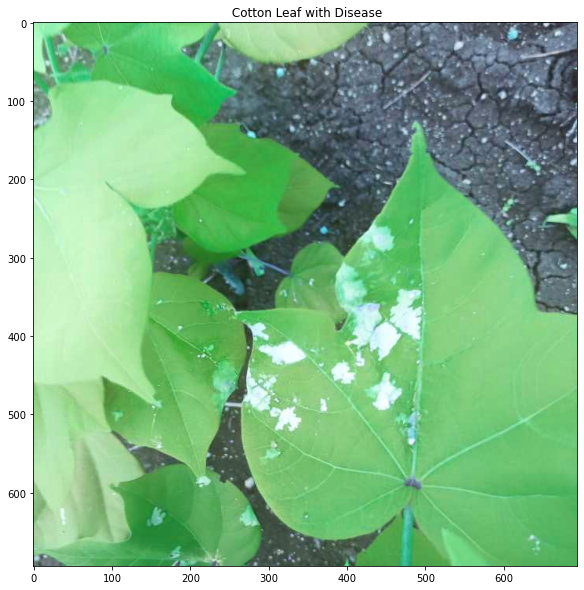

In [3]:
image = cv2.imread('./Cotton Disease/train/diseased cotton leaf/dis_leaf (101)_iaip.jpg')
plt.figure(figsize=(10,10)) 
plt.title(' Cotton Leaf with Disease')
plt.imshow(image)

In [4]:
train_datagenerator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2]
                                        )
test_datagenerator = ImageDataGenerator(rescale = 1.0/255)

In [5]:
train_data = train_datagenerator.flow_from_directory('./Cotton Disease/train',
                                                    target_size = (224,224),
                                                    batch_size = 64,
                                                    class_mode = 'categorical')
test_data = test_datagenerator.flow_from_directory('./Cotton Disease/val',
                                                  target_size = (224,224),
                                                    batch_size = 64,
                                                    class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 253 images belonging to 4 classes.


In [6]:
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 224, 224, 3
n_classes = 4
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [7]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
run = model.fit(x = train_data, validation_data = test_data, epochs = 50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 4 steps
Epoch 1/50
31/31 [==============================] - 479s 15s/step - loss: 1.6754 - accuracy: 0.4885 - val_loss: 2.8180 - val_accuracy: 0.2688
Epoch 2/50
31/31 [==============================] - 453s 15s/step - loss: 1.0426 - accuracy: 0.5654 - val_loss: 5.3528 - val_accuracy: 0.1700
Epoch 3/50
31/31 [==============================] - 448s 14s/step - loss: 0.9584 - accuracy: 0.6258 - val_loss: 2.4191 - val_accuracy: 0.2727
Epoch 4/50
31/31 [==============================] - 450s 15s/step - loss: 0.8355 - accuracy: 0.6586 - val_loss: 3.4955 - val_accuracy: 0.2846
Epoch 5/50
31/31 [==============================] - 456s 15s/step - loss: 0.8686 - accuracy: 0.6638 - val_loss: 1.2702 - val_accuracy: 0.5613
Epoch 6/50
31/31 [==============================] - 443s 14s/step - loss: 0.7504 - accuracy: 0.7058 - val_loss: 1.3872 - val_accuracy: 0.3913
Epoch 7/50
31/31 [==============================] - 447s 

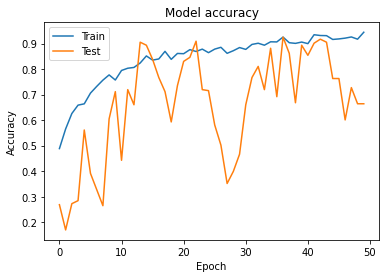

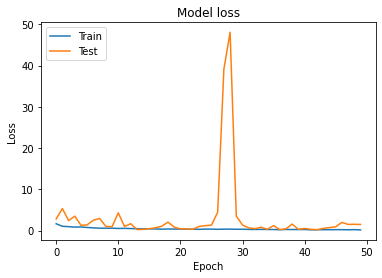

In [9]:
plt.plot(run.history['accuracy'])
plt.plot(run.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(run.history['loss'])
plt.plot(run.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()